## import libraries

In [1]:
# mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os

import pandas as pd
import numpy as np
import re

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

os.chdir('/content/gdrive/My Drive/IMT574_grader')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## load data

In [3]:
df_chicago = pd.read_csv("https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD")
df_chicago.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [4]:
df_chicago.to_pickle("./df_chicago.pkl")

In [5]:
df_NY = pd.read_csv("https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD")
df_NY.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,885776788,66,NaN,12/23/2020,19:50:00,NaN,NaN,COMPLETED,NaN,NaN,NaN,N.Y. POLICE DEPT,101,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,NaN,12/23/2020,NaN,NaN,NaN,NaN,NaN,18-24,BLACK,M,986633,167258,40.625769,-73.991417,"(40.62576896100006, -73.99141682199996)",POINT (-73.99141682199996 40.62576896100006)
1,350637195,77,NaN,12/21/2020,01:10:00,NaN,NaN,COMPLETED,NaN,NaN,NaN,N.Y. POLICE DEPT,101,FELONY,INSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,NaN,12/21/2020,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,1003606,185050,40.674583,-73.930222,"(40.67458330800008, -73.93022154099998)",POINT (-73.93022154099998 40.67458330800008)
2,347843168,43,BRONX,11/22/2020,22:00:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,104,FELONY,NaN,RAPE,NaN,PATROL BORO BRONX,157.0,RAPE 1,STREET,11/23/2020,NaN,UNKNOWN,UNKNOWN,U,NaN,25-44,BLACK,F,1020316,239179,40.823101,-73.869690,"(40.82310129900002, -73.86969046099993)",POINT (-73.86969046099993 40.82310129900002)
3,197941396,47,NaN,11/22/2020,09:50:00,NaN,NaN,COMPLETED,NaN,NaN,NaN,N.Y. POLICE DEPT,101,FELONY,INSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,NaN,11/22/2020,NaN,25-44,BLACK,M,NaN,25-44,BLACK,F,1026387,262634,40.887451,-73.847608,"(40.88745131300004, -73.84760778699997)",POINT (-73.84760778699997 40.88745131300004)
4,298404927,25,NaN,11/21/2020,15:38:00,NaN,NaN,COMPLETED,NaN,NaN,NaN,N.Y. HOUSING POLICE,101,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,NaN,11/21/2020,NaN,NaN,NaN,NaN,NaN,18-24,BLACK HISPANIC,M,1003396,230824,40.800222,-73.930848,"(40.80022202900005, -73.93084834199995)",POINT (-73.93084834199995 40.80022202900005)


In [6]:
df_NY_geo = pd.read_csv("https://data.cityofnewyork.us/api/views/kmub-vria/rows.csv?accessType=DOWNLOAD")
df_NY_geo.head()

,Shape_Leng,the_geom,Shape_Area,Precinct
0,80969.426497,MULTIPOLYGON (((-74.0438776157395 40.690187676...,4.731588e+07,1
1,18676.124259,MULTIPOLYGON (((-73.98863862848766 40.72293372...,1.808880e+07,5
2,26402.900691,MULTIPOLYGON (((-73.99968392160721 40.73855224...,2.209819e+07,6
3,29978.094261,MULTIPOLYGON (((-73.92854313809303 40.66457328...,4.533179e+07,71
4,87968.194520,MULTIPOLYGON (((-73.99840899113158 40.67186872...,1.046213e+08,72


In [7]:
df_NY.to_pickle("./df_NY.pkl")

In [8]:
df_chicago.shape

(7295108, 22)

In [9]:
df_NY.shape

(413412, 36)

## preprocess data

#### Chicago

In [10]:
df_chicago = pd.read_pickle("./df_chicago.pkl")

In [11]:
df_chicago.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [12]:
df_chicago.Year.value_counts()

2002    486766
2001    485798
2003    475963
2004    469401
2005    453746
2006    448145
2007    437056
2008    427119
2009    392784
2010    370420
2011    351897
2012    336164
2013    307345
2014    275598
2016    269538
2017    268761
2018    268337
2015    264509
2019    260597
2020    210352
2021     34812
Name: Year, dtype: int64

In [13]:
df_chicago = df_chicago[df_chicago.Year == 2020]
df_chicago.shape

(210352, 22)

In [14]:
df_chicago.isna().sum()

ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description    1174
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                       9
Community Area             1
FBI Code                   0
X Coordinate            1828
Y Coordinate            1828
Year                       0
Updated On                 0
Latitude                1828
Longitude               1828
Location                1828
dtype: int64

In [15]:
df_chicago = df_chicago.dropna()

In [16]:
df_chicago = df_chicago[df_chicago["Primary Type"].str.contains('ROBBERY|ARSON|HOMICIDE|ASSAULT')]
df_chicago['Primary Type'] = df_chicago['Primary Type'].apply(lambda x: "ASSAULT" if "ASSAULT" in x else x)

In [17]:
df_chicago.Date = df_chicago.Date.astype('datetime64')
df_chicago["month"] = df_chicago.Date.dt.month

In [18]:
df_chicago = df_chicago[['Primary Type','Arrest', 'Domestic', 'Beat','District', 'Ward', 'Community Area', 'FBI Code', 'Latitude', 'Longitude', "month"]]

In [19]:
df_chicago.dtypes

Primary Type       object
Arrest               bool
Domestic             bool
Beat                int64
District          float64
Ward              float64
Community Area    float64
FBI Code           object
Latitude          float64
Longitude         float64
month               int64
dtype: object

In [20]:
df_chicago["District"] = df_chicago["District"].astype(int)
df_chicago["Ward"] = df_chicago["Ward"].astype(int)
df_chicago["Community Area"] = df_chicago["Community Area"].astype(int)

In [21]:
label_encoder = preprocessing.LabelEncoder() 

df_chicago['encode_type']= label_encoder.fit_transform(df_chicago['Primary Type'])
df_chicago['encode_Arrest']= label_encoder.fit_transform(df_chicago['Arrest'])
df_chicago['encode_Domestic']= label_encoder.fit_transform(df_chicago['Domestic'])
df_chicago["encode_Beat"] = label_encoder.fit_transform(df_chicago["Beat"])
df_chicago["encode_FBI Code"] = label_encoder.fit_transform(df_chicago["FBI Code"])

In [22]:
df_chicago.shape

(28587, 16)

In [23]:
df_chicago.head()

,Primary Type,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,month,encode_type,encode_Arrest,encode_Domestic,encode_Beat,encode_FBI Code
813,ASSAULT,False,False,2525,25,35,20,08A,41.923369,-87.731634,3,1,0,0,268,5
3059,ROBBERY,False,False,1021,10,24,29,03,41.860148,-87.712804,3,3,0,0,120,3
13394,ASSAULT,False,True,835,8,18,70,04A,41.750972,-87.682871,3,1,0,1,100,4
64851,ASSAULT,False,False,2423,24,49,1,08A,42.009077,-87.668581,3,1,0,0,254,5
67424,ROBBERY,False,False,723,7,6,68,03,41.770145,-87.648175,12,3,0,0,77,3


#### New York City

In [24]:
df_NY.head(3)

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,885776788,66,NaN,12/23/2020,19:50:00,NaN,NaN,COMPLETED,NaN,NaN,NaN,N.Y. POLICE DEPT,101,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,NaN,12/23/2020,NaN,NaN,NaN,NaN,NaN,18-24,BLACK,M,986633,167258,40.625769,-73.991417,"(40.62576896100006, -73.99141682199996)",POINT (-73.99141682199996 40.62576896100006)
1,350637195,77,NaN,12/21/2020,01:10:00,NaN,NaN,COMPLETED,NaN,NaN,NaN,N.Y. POLICE DEPT,101,FELONY,INSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,NaN,12/21/2020,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,1003606,185050,40.674583,-73.930222,"(40.67458330800008, -73.93022154099998)",POINT (-73.93022154099998 40.67458330800008)
2,347843168,43,BRONX,11/22/2020,22:00:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,104,FELONY,NaN,RAPE,NaN,PATROL BORO BRONX,157.0,RAPE 1,STREET,11/23/2020,NaN,UNKNOWN,UNKNOWN,U,NaN,25-44,BLACK,F,1020316,239179,40.823101,-73.869690,"(40.82310129900002, -73.86969046099993)",POINT (-73.86969046099993 40.82310129900002)


In [25]:
df_NY.CMPLNT_FR_DT =  df_NY.CMPLNT_FR_DT.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').date())
df_NY["year"] = df_NY.CMPLNT_FR_DT.apply(lambda x: x.year)
df_NY["month"] = df_NY.CMPLNT_FR_DT.apply(lambda x: x.month)

In [26]:
df_NY = df_NY[df_NY["year"] == 2020]
df_NY.shape

(404892, 38)

In [27]:
df_NY.isna().sum()

CMPLNT_NUM                       0
ADDR_PCT_CD                      0
BORO_NM                        463
CMPLNT_FR_DT                     0
CMPLNT_FR_TM                     0
CMPLNT_TO_DT                 37978
CMPLNT_TO_TM                 37859
CRM_ATPT_CPTD_CD                 0
HADEVELOPT                  403351
HOUSING_PSA                 374475
JURISDICTION_CODE              441
JURIS_DESC                       0
KY_CD                            0
LAW_CAT_CD                       0
LOC_OF_OCCUR_DESC            65281
OFNS_DESC                        5
PARKS_NM                    402239
PATROL_BORO                    441
PD_CD                          441
PD_DESC                        441
PREM_TYP_DESC                 1104
RPT_DT                           0
STATION_NAME                397933
SUSP_AGE_GROUP               92098
SUSP_RACE                    92098
SUSP_SEX                     92098
TRANSIT_DISTRICT            397933
VIC_AGE_GROUP                    1
VIC_RACE            

In [28]:
df_NY.columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'Lat_Lon', 'New Georeferenced Column', 'year', 'month'],
      dtype='object')

In [29]:
df_NY = df_NY[['ADDR_PCT_CD', 'BORO_NM', 'JURISDICTION_CODE', "KY_CD", "LAW_CAT_CD", 'OFNS_DESC', 'PD_CD', 'SUSP_AGE_GROUP',
                'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'year', 'month']]
df_NY = df_NY.dropna()
df_NY = df_NY[df_NY["OFNS_DESC"].str.contains('ROBBERY|ARSON|HOMICIDE|ASSAULT')]
df_NY.shape

(72489, 17)

In [30]:
df_NY["OFNS_DESC"].value_counts()

ASSAULT 3 & RELATED OFFENSES      40599
FELONY ASSAULT                    18906
ROBBERY                           12600
ARSON                               372
HOMICIDE-NEGLIGENT,UNCLASSIFIE       12
Name: OFNS_DESC, dtype: int64

In [31]:
df_NY["Primary Type"] = df_NY["OFNS_DESC"].apply(lambda x: "ASSAULT" if "ASSAULT" in x else x)
df_NY["Primary Type"] = df_NY["Primary Type"].apply(lambda x: "HOMICIDE" if "HOMICIDE" in x else x)

In [32]:
df_NY["JURISDICTION_CODE"] = df_NY["JURISDICTION_CODE"].astype(int)
df_NY["PD_CD"] = df_NY["PD_CD"].astype(int)

In [33]:
label_encoder = preprocessing.LabelEncoder() 

df_NY['encode_LAW_CAT_CD']= label_encoder.fit_transform(df_NY['LAW_CAT_CD'])
df_NY['encode_type']= label_encoder.fit_transform(df_NY['Primary Type'])
df_NY["encode_SUSP_AGE_GROUP"] = label_encoder.fit_transform(df_NY["SUSP_AGE_GROUP"])
df_NY["encode_SUSP_RACE"] = label_encoder.fit_transform(df_NY["SUSP_RACE"])
df_NY['encode_SUSP_SEX']= label_encoder.fit_transform(df_NY['SUSP_SEX'])
df_NY["encode_VIC_AGE_GROUP"] = label_encoder.fit_transform(df_NY["VIC_AGE_GROUP"])
df_NY["encode_VIC_RACE"] = label_encoder.fit_transform(df_NY["VIC_RACE"])

In [34]:
df_NY.head()

,ADDR_PCT_CD,BORO_NM,JURISDICTION_CODE,KY_CD,LAW_CAT_CD,OFNS_DESC,PD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Latitude,Longitude,year,month,Primary Type,encode_LAW_CAT_CD,encode_type,encode_SUSP_AGE_GROUP,encode_SUSP_RACE,encode_SUSP_SEX,encode_VIC_AGE_GROUP,encode_VIC_RACE
86,75,BROOKLYN,0,344,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,113,UNKNOWN,BLACK HISPANIC,M,65+,BLACK,M,40.673761,-73.878804,2020,12,ASSAULT,1,1,7,3,1,8,2
91,43,BRONX,2,105,FELONY,ROBBERY,388,25-44,BLACK,M,25-44,BLACK,F,40.826163,-73.871151,2020,12,ROBBERY,0,3,3,2,1,6,2
108,114,QUEENS,0,105,FELONY,ROBBERY,396,25-44,BLACK,M,UNKNOWN,UNKNOWN,D,40.753159,-73.911623,2020,12,ROBBERY,0,3,3,2,1,11,4
111,23,MANHATTAN,0,344,MISDEMEANOR,ASSAULT 3 & RELATED OFFENSES,101,UNKNOWN,WHITE HISPANIC,U,25-44,WHITE HISPANIC,F,40.792649,-73.951268,2020,12,ASSAULT,1,1,7,6,2,6,6
115,76,BROOKLYN,0,114,FELONY,ARSON,263,UNKNOWN,UNKNOWN,U,UNKNOWN,UNKNOWN,E,40.689654,-73.997643,2020,12,ARSON,0,0,7,4,2,11,4


## build models

####Visualization

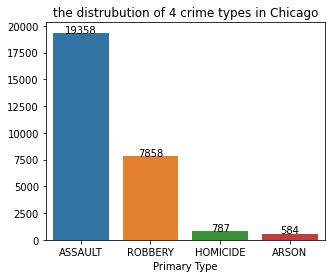

In [35]:
type_chicago = df_chicago["month"].groupby(df_chicago["Primary Type"]).count().sort_values(ascending=False)

plt.figure(figsize = (5, 4))
ax = sns.barplot(x= type_chicago.index, y= type_chicago.values)
ax.set_title("the distrubution of 4 crime types in Chicago")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1, type_chicago.values[i],ha="center")

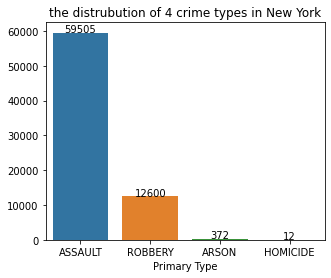

In [36]:
type_NY = df_NY["month"].groupby(df_NY["Primary Type"]).count().sort_values(ascending=False)

plt.figure(figsize = (5, 4))
ax = sns.barplot(x= type_NY.index, y= type_NY.values)
ax.set_title("the distrubution of 4 crime types in New York")
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 30, type_NY.values[i],ha="center")

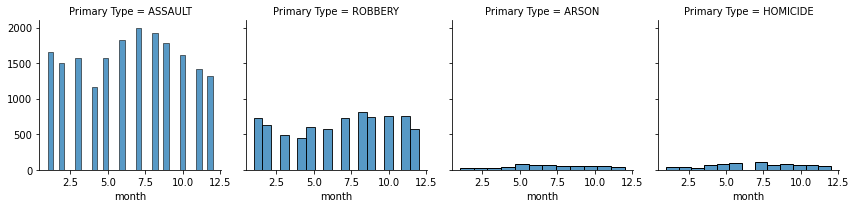

In [37]:
g = sns.FacetGrid(df_chicago, col ="Primary Type")
g.map(sns.histplot, "month")
plt.show()

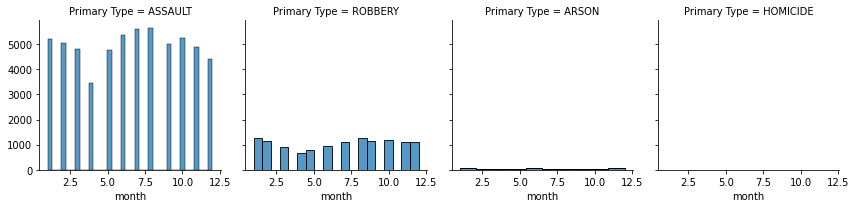

In [38]:
g = sns.FacetGrid(df_NY, col ="Primary Type")
g.map(sns.histplot, "month")
plt.show()

#### Use several features to predict the types of crimes
- Chicago

In [39]:
#Creating X and y
X = df_chicago[['Latitude', 'Longitude', 'encode_Arrest', 'encode_Domestic', 'encode_Beat', 'encode_FBI Code']]
y = df_chicago[['encode_type']]

#Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#Creating Logisitic Regression model
model = LogisticRegression()
model.fit(X_train,y_train)

#Predicting on Test set
predictions = model.predict(X_test)

print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

0.9235163810190044
[[   0  175    0    0]
 [   0 5588    0  271]
 [   0    0  223    1]
 [   0  209    0 2110]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.94      0.95      0.94      5859
           2       1.00      1.00      1.00       224
           3       0.89      0.91      0.90      2319

    accuracy                           0.92      8577
   macro avg       0.71      0.71      0.71      8577
weighted avg       0.90      0.92      0.91      8577



- New York

In [42]:
#Creating X and y
X = df_NY[['month', 'Latitude', 'Longitude', 'encode_LAW_CAT_CD', 'encode_SUSP_AGE_GROUP', 
           'encode_SUSP_RACE', 'encode_SUSP_SEX', 'encode_VIC_AGE_GROUP', 'encode_VIC_RACE']]
y = df_NY[['encode_type']]

#Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#Creating Logisitic Regression model
model = LogisticRegression()
model.fit(X_train,y_train)

#Predicting on Test set
predictions = model.predict(X_test)

print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

0.8435186462500575
[[    0    20     0    95]
 [    0 17239     0   707]
 [    0     0     0     1]
 [    0  2580     0  1105]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.87      0.96      0.91     17946
           2       0.00      0.00      0.00         1
           3       0.58      0.30      0.40      3685

    accuracy                           0.84     21747
   macro avg       0.36      0.32      0.33     21747
weighted avg       0.82      0.84      0.82     21747

